## BloomTech Data Science

---


# Wrangle ML datasets
- Explore tabular data for supervised machine learning
- Join relational data for supervised machine learning

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [2]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import tarfile
from IPython.display import Image

# I. Wrangle Data

1. Download the data [HERE](https://www.kaggle.com/datasets/psparks/instacart-market-basket-analysis) by clicking the **Download** button on the top right corner of the page.
2. Upload the file to your Google Drive in a folder named "Instacart"

In [ ]:
# download data via http

# def download(url):
#   filename = url.split('/')[-1] # gets everything after the / in the url
#   print(f'Downloading {url}')
#   r = requests.get(url) # request to url
#   with open(filename, 'wb') as f: # wb is write binary. Python makes no changes to file. Text mode encodes as default text encoding (file is corrupted likely)
#     f.write(r.content)
#   print(f'Downloaded {filename}')

# download('https://lambdaschool-ds-instruction.s3.amazonaws.com/datasets%3Ainstacart_2017_05_01.tar.gz')

In [ ]:
# uncompress data
# tarfile.open('datasets%3Ainstacart_2017_05_01.tar.gz').extractall()

In [ ]:
# change directory to where the data was uncompressed
# !cd instacart_2017_05_01

In [ ]:
# print the csv filenames
# pattern = 'instacart_2017_05_01/*csv'

# for filename in glob(pattern):
#   print(filename)

In [5]:
# mounting your google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
#change your working directory, if you want to or have already saved your kaggle dataset on google drive.
%cd /content/gdrive/My Drive/Instacart

/content/gdrive/My Drive/Instacart


In [7]:
!ls

aisles.csv	 order_products__prior.csv  orders.csv
departments.csv  order_products__train.csv  products.csv


In [ ]:
# Unzip the files, if you haven't already done so.
# !unzip \*.zip  && rm *.zip

**Before you start,** load each of the above `.csv` files into its own DataFrame.

In [36]:
orders = pd.read_csv('orders.csv')
order_products_train = pd.read_csv('order_products__train.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
products = pd.read_csv('products.csv')

In [9]:
Image(url= "https://i.imgur.com/R7c37Yw.png")

## I.a. Warm-up Questions

What information is contained in the column `orders['eval_set']`?

In [37]:
orders['eval_set'].describe()

,eval_set
count,3421083
unique,3
top,prior
freq,3214874


In [38]:
# which set the order belongs to. Prior is the subset of data which is the last order for each customer. Training is to train the model. Test is final evaluation.
orders['eval_set'].value_counts()

,count
eval_set,
prior,3214874
train,131209
test,75000


The first row of `orders['order_id']` is `2539329`. Where can we find the items that were included in that order?

In [39]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [40]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [41]:
mask1 = (order_products_prior['order_id'] == 2539329)
order_products_prior[mask1]

,order_id,product_id,add_to_cart_order,reordered
24076664,2539329,196,1,0
24076665,2539329,14084,2,0
24076666,2539329,12427,3,0
24076667,2539329,26088,4,0
24076668,2539329,26405,5,0


The first row of `order_products__prior['product_id']` is `33120`. What is the name of that product?

In [42]:
mask2 = (products['product_id'] == 33120)
products[mask2]

,product_id,product_name,aisle_id,department_id
33119,33120,Organic Egg Whites,86,16


# Define Our Machine Learning Problem

- We want predict whether or not a customer will purchase a specific item (of our choosing).
- The most commonly ordered product: `'Banana'` (`24852`).
- Our model is going to predict whether or not an order will include a `'Banana'`.

Lets adjust the Kaggle competition classification task from "What products will be ordered?" (multiclass, multilabel classification) to "Will one product be reordered?" (binary classification).

In [43]:
order_products_prior['product_id'].value_counts().head()

,count
product_id,
24852,472565
13176,379450
21137,264683
21903,241921
47209,213584


In [44]:
mask3 = (products['product_id'] == 24852)
products[mask3]

,product_id,product_name,aisle_id,department_id
24851,24852,Banana,24,4


## I.c. Create Feature Matrix and Target Vector

Our **feature matrix** will be all the `'train'` rows from `orders`.

Our **target vector** will be whether or not each order in `X` contains the item we've chosen above.

In [45]:
train_mask = (orders['eval_set'] == 'train')

X = orders[train_mask].copy()

X.drop(columns='eval_set', inplace=True)

In [46]:
X.shape

(131209, 6)

In [47]:
X.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,11,4,8,14.0
25,1492625,2,15,1,11,30.0
49,2196797,5,5,0,11,6.0
74,525192,7,21,2,11,6.0
78,880375,8,4,1,14,10.0


In [48]:
order_products_train['is_banana'] = order_products_train['product_id'] == 24852

In [49]:
banana_orders = order_products_train[order_products_train['is_banana']]['order_id']

In [50]:
X['includes_bananas'] = X['order_id'].isin(banana_orders).astype(int)

In [51]:
X['includes_bananas']

,includes_bananas
10,0
25,1
49,0
74,0
78,0
...,...
3420838,0
3420862,0
3420924,0
3420933,1


# I.d Feature Engineering

## What features can we engineer? We want to predict, will these customers reorder bananas on their next order?

- Products per order
- Time of day
- Have they reordered bananas before? (Have ordered bananas >= 2 times)
- Other fruit they buy
- Size of orders (customers with smaller orders on average are less likely to be reordering any particular product on their next order)


- Frequency of banana orders:
    - % of orders
    - Time between banana orders: Every n days on average
    - Raw count: Total orders, how many times have you ordered bananas?

- Recency of banana orders
    - n days since you ordered banana



Is an order placed before 11:00AM?

In [52]:
X['morning_order'] = (X['order_hour_of_day'] <= 11).astype(int)

In [53]:
X.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,includes_bananas,morning_order
10,1187899,1,11,4,8,14.0,0,1
25,1492625,2,15,1,11,30.0,1,1
49,2196797,5,5,0,11,6.0,0,1
74,525192,7,21,2,11,6.0,0,1
78,880375,8,4,1,14,10.0,0,0


How many items in the order?

In [54]:
n_items_per_order = order_products_train.groupby('order_id')['product_id'].count().rename('n_items')

In [55]:
X = X.merge(n_items_per_order, how='left', left_on='order_id', right_index=True) # use the index from the right df as the join key

In [56]:
X.shape

(131209, 9)

In [57]:
X.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,includes_bananas,morning_order,n_items
10,1187899,1,11,4,8,14.0,0,1,11
25,1492625,2,15,1,11,30.0,1,1,31
49,2196797,5,5,0,11,6.0,0,1,9
74,525192,7,21,2,11,6.0,0,1,9
78,880375,8,4,1,14,10.0,0,0,18


Did the user order `'Banana'` in previous orders?

In [58]:

order_products_prior['is_banana'] = order_products_prior['product_id'] == 24852
banana_orders_id_prior = order_products_prior[order_products_prior['is_banana']]['order_id']


prior_orders = orders[orders['eval_set']=='prior'].copy()
prior_orders['has_banana'] = prior_orders['order_id'].isin(banana_orders_id_prior)


prior_banana_user_ids = prior_orders[prior_orders['has_banana']]['user_id'].unique()

X['prior_banana_orders'] = X['user_id'].isin(prior_banana_user_ids).astype(int)

In [59]:
X.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,includes_bananas,morning_order,n_items,prior_banana_orders
10,1187899,1,11,4,8,14.0,0,1,11,0
25,1492625,2,15,1,11,30.0,1,1,31,1
49,2196797,5,5,0,11,6.0,0,1,9,0
74,525192,7,21,2,11,6.0,0,1,9,0
78,880375,8,4,1,14,10.0,0,0,18,0


In [60]:
X.shape

(131209, 10)

# II. Split Data

In [61]:
target = 'includes_bananas'

y = X[target]

X = X.drop(columns=['order_id', 'user_id', 'order_number', target])

In [62]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)

# III. Establish Baseline

In [63]:
print('Baseline accuracy:', y_train.value_counts(normalize=True).max())

Baseline accuracy: 0.8569931502281669


<Axes: xlabel='includes_bananas'>

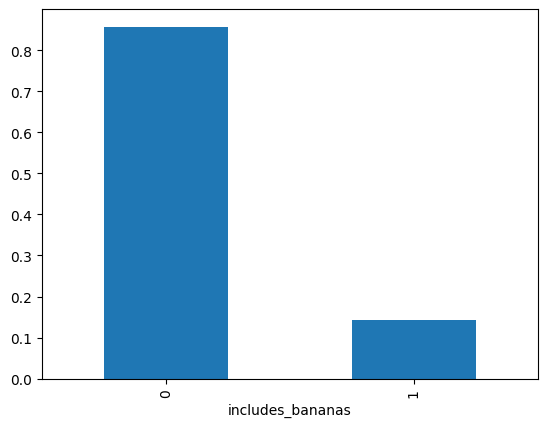

In [64]:
y_train.value_counts(normalize=True).plot(kind='bar')

# IV. Build Model

In [65]:
model_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

model_rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

# V. Check Metrics

In [66]:
print('RF Training Accuracy:', model_rf.score(X_train, y_train))
print('RF Validation Accuracy:', model_rf.score(X_val, y_val))

RF Training Accuracy: 0.9464403098116551
RF Validation Accuracy: 0.8386555902751315


In [67]:
print('RF Training Accuracy:', model_rf.score(X_train, y_train))
print('RF Validation Accuracy:', model_rf.score(X_val, y_val))


RF Training Accuracy: 0.9464403098116551
RF Validation Accuracy: 0.8386555902751315
